In [283]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('dragon.jpg')

Here is the image I took:
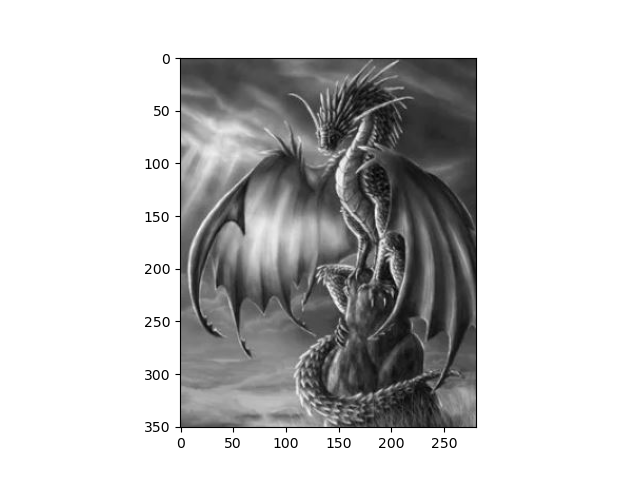

# Q1

You are given an rgb image (3 channels). We wish to find the features in the image using a new method. 
In our method, a pixel is considered a corner if it meets the following condition: 
The mean color distance (MCD) of the pixel and its neighbors is greater than some threshold. color distance is defined by:
                          
                          Color distance = euclidean_distance((r1,g1,b1),(r2,g2,b2))
                              
r - red, g - green, b- blue

The neighbors are defined by an input variable which defines the amount of neighbor pixels to be considered.
Neighbor pixel - pixel in a square of size radius * radius around the pixel.

Please implement a function that gets 2 pixels from an image and calculates the CD and the pixel distance between them.
                              
                              Pixel distance = euclidean_distance((px1_x,px1_y),(px2_x,px2_y))
Test the functions on:

                     print(calc_color_dist([156,232,111],[214,44,89]))

                     print(calc_pixel_dist([38,42],[3,1]))

In [284]:
def calc_color_dist(pix_color1, pix_color2):
    return np.sqrt((pix_color1[0] - pix_color2[0]) ** 2 + (pix_color1[1] - pix_color2[1]) ** 2 + (pix_color1[1] - pix_color2[1]) ** 2)


def calc_pixel_dist(pixel_loc1, pixel_loc2):
    return np.sqrt((pixel_loc1[0] - pixel_loc2[0]) ** 2 + (pixel_loc1[1] - pixel_loc2[1]) ** 2)

# Q2

Please implement a function that receives an image, threshold value and neighbor_radius and finds all the features in the image.

In [285]:
def find_features(image, th, neighbor_radius):
    assert th > 0
    pad = neighbor_radius
    padded_img = cv2.copyMakeBorder(image, pad, pad, pad, pad,
                                    cv2.BORDER_CONSTANT,
                                    value=(0,0,0))
    height, width, _ = padded_img.shape
    kernel_size = neighbor_radius * 2 + 1
    features = list()
    for y in range(pad, height - pad):
        for x in range(pad, width - pad):
            pixel_rgb = padded_img[y, x]
            pixel_rgb_kernel = np.zeros((kernel_size, kernel_size, 3)) + pixel_rgb
            cur_image_region = padded_img[y - neighbor_radius : y + neighbor_radius + 1,
                                     x - neighbor_radius : x + neighbor_radius + 1]
            num_of_neighbors = kernel_size ** 2 - 1
            score = np.sum(np.sqrt(np.sum((pixel_rgb_kernel - cur_image_region) ** 2, axis=2))) / num_of_neighbors
            if score > th :
                features.append([y, x])
    return features

In [286]:
th = 120
neighbor_radius = 2
features = find_features(img, th, neighbor_radius)
print(len(features))

505


In [287]:
#regular implementations with loops
def find_features_regular(image, th, neighbor_radius):
    assert th > 0
    pad = neighbor_radius
    padded_img = cv2.copyMakeBorder(image, pad, pad, pad, pad,
                                    cv2.BORDER_CONSTANT,
                                    value=(0, 0, 0))
    height, width, _ = padded_img.shape
    kernel_size = neighbor_radius * 2 + 1
    features = list()
    for y in range(pad, height - pad):
        for x in range(pad, width - pad):
            pixel_rgb = padded_img[y, x]
            cur_sum = 0
            for j in range(kernel_size):
                for i in range(kernel_size):
                    cur_neighbour = padded_img[y + j - neighbor_radius, x + i - neighbor_radius]
                    cur_sum += calc_color_dist(pixel_rgb.astype("float32"), cur_neighbour.astype("float32"))
                    # .astype("float32") because of overflow 0 - 1 = 255 as type uint8 as the image type 
            num_of_neighbors = kernel_size ** 2 - 1
            score = cur_sum / num_of_neighbors
            if score > th:
                features.append([y, x])

    return features

In [288]:
th = 120
neighbor_radius = 2
features_regular = find_features_regular(img, th, neighbor_radius)
print(len(features))

505


In [289]:
check_regular_in_features =  all(item in features for item in features_regular)
print(check_regular_in_features)
check_features_in_regular =  all(item in features_regular for item in features)
print(check_features_in_regular)

print("Equal result in two different approaches")

True
True
Equal result in two different approaches


# Notice the run time difference in run time for only 2 neighbours_radius (means a 5 x 5 region of neighbourhood is looked at as it is 2 neighbours from each side, including the diagonals):

Without inner loops on neighbours: 



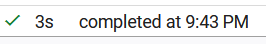

With inner loops on neighbours: 



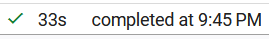

# Q3

explain how would you implement the following changes:

    1. Instead of square take a circle
    2. Minimal distance between features is defined by new parameter minimal_distance
    3. Take only the top best features defined by parameter max_features

# Q3.1 code


In [290]:
def compute_mask_for_circle_radius(circle_radius):
    circle_range = list(range(- circle_radius, circle_radius + 1))
    kernel_size = circle_radius * 2 + 1
    neighbors_indices_y = np.asarray(circle_range).reshape(-1, kernel_size).repeat(kernel_size, axis=0)
    neighbors_indices_x = np.asarray(circle_range).reshape(kernel_size, -1).repeat(kernel_size, axis=-1)

    neighbors_indices = np.stack((neighbors_indices_y, neighbors_indices_x), axis=-1)
    spatial_distance = np.sqrt(np.sum((neighbors_indices ** 2), axis=-1))
    circle_mask = (spatial_distance < circle_radius).astype("int")

    return circle_mask

In [291]:
def aux_find(image, th, circle_radius, circle_mask):
    assert th > 0
    pad = circle_radius
    padded_img = cv2.copyMakeBorder(image, pad, pad, pad, pad,
                                    cv2.BORDER_CONSTANT,
                                    value=(0, 0, 0))
    height, width, _ = padded_img.shape
    features = list()

    circle_mask_area = np.sum(circle_mask) - 1

    kernel_size = circle_radius * 2 + 1
    for y in range(pad, height - pad):
        for x in range(pad, width - pad):
            pixel_rgb = padded_img[y, x]
            prgb_kernel = np.zeros((kernel_size, kernel_size, 3)) + pixel_rgb
            cur_image_region = padded_img[y - circle_radius: y + circle_radius + 1,
                               x - circle_radius: x + circle_radius + 1]
            squared_diff = (prgb_kernel - cur_image_region) ** 2
            masked_by_circle = circle_mask[..., np.newaxis].repeat(3, axis=-1) * squared_diff
            score = np.sum(np.sqrt(np.sum(masked_by_circle, axis=2))) / circle_mask_area
            if score > th:
                features.append([y, x])
    return features

In [292]:
def find_features_in_circle(image, th, circle_radius):
    circle_mask = compute_mask_for_circle_radius(circle_radius)
    features = aux_find(image, th, circle_radius, circle_mask)
    return features

In [293]:
th = 120
neighbor_radius = 2
features_circle = find_features_in_circle(img, th, neighbor_radius)
print(len(features))

505


In [294]:
#regular implementations with loops
def find_features_in_circle_regular(image, th, circle_radius):
    assert th > 0
    pad = neighbor_radius
    padded_img = cv2.copyMakeBorder(image, pad, pad, pad, pad,
                                    cv2.BORDER_CONSTANT,
                                    value=(0, 0, 0))
    height, width, _ = padded_img.shape
    kernel_size = neighbor_radius * 2 + 1
    features = list()
    for y in range(pad, height - pad):
        for x in range(pad, width - pad):
            pixel_rgb = padded_img[y, x]
            cur_sum = 0
            count_neighbours = 0
            for j in range(kernel_size):
                for i in range(kernel_size):
                    if np.sqrt((j - neighbor_radius) ** 2 + (i - neighbor_radius) ** 2) < circle_radius:
                        cur_neighbour = padded_img[y + j - neighbor_radius, x + i - neighbor_radius]
                        cur_sum += calc_color_dist(pixel_rgb.astype("float32"), cur_neighbour.astype("float32"))
                        # .astype("float32") because of overflow 0 - 1 = 255 as type uint8 as the image type
                        count_neighbours += 1
            num_of_neighbors = count_neighbours - 1
            score = cur_sum / num_of_neighbors
            if score > th:
                features.append([y, x])

    return features

In [295]:
th = 120
circle_radius = 2
features_circle_regular = find_features_in_circle_regular(img, th, circle_radius)
print(len(features))

505


In [296]:
check_regular_in_features_circle =  all(item in features_circle for item in features_circle_regular)
print(check_regular_in_features_circle)
check_features_in_regular_circle =  all(item in features_circle_regular for item in features_circle)
print(check_features_in_regular_circle)

print("Equal result in two different approaches")

True
True
Equal result in two different approaches


And we get less features using a circle instead of all square neighbourhood as expected (smaller perceptive field).

# Q3.2 code

For this question there is two ways, one simple and less efficient, and one a little bit more complex but more efficient in means of complexity of computation (especially if number of featrues is big and squared compelxity is too much).

The first is run the algorithm and then loop twice to find if the distance of each element to each element sattisfies the condition.

The seocnd is actually during the computation skip few elements til the next element which sattisfies the min_distance term. It is a little bit cumbersome for implementation, as after adding a feature, a region of radius min_distance (a circle to be accurate) should be marked (for exmaple the color could be set negative) as non-valid for being checked for the threshold condition. And the margins should be treated as a special case, also for the marking (only part of the circle from the center is relevant).

Here I'll implement the first.

Later there is an attempt to implement the second.


Here are some illustration for the second method:

Our circle of radius min_distace with which we mark all the elements that should'nt be check for MCD because the current feature at [y,x] was taken. *italicized text*

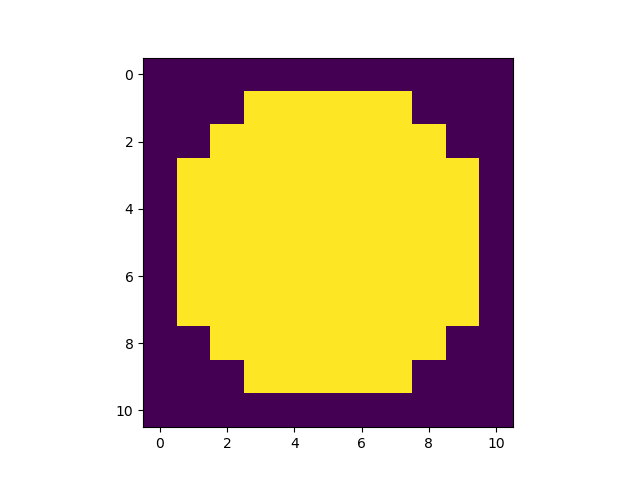


An example of region we are looking for feature:

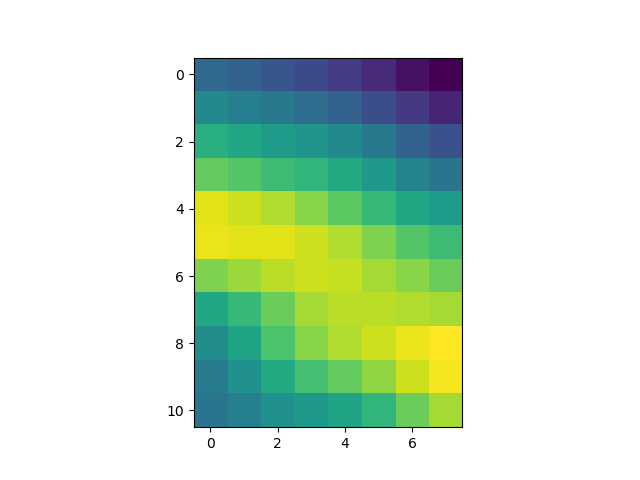

And you can guess that the feature is th marked one in X, which the neighbourghood marked and the min_distance, which shows it exceeds the image left border:

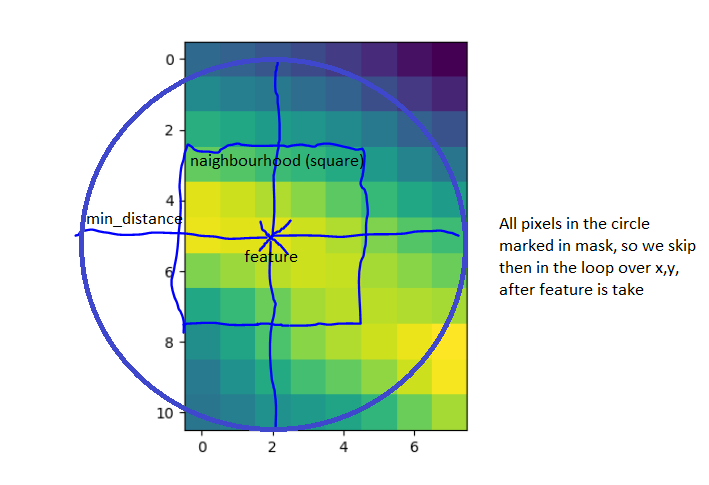

In the region of image (only opne channel is showed) there is a feature for which min_distance is from left is bigger then the actual size of the image from the left, so the circle should be moderated appropriately, for this exmaple it would look like this:

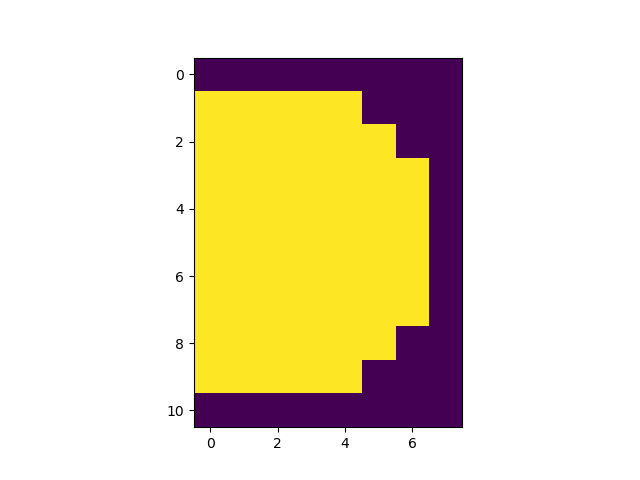

For each border line when min_distacne region exceeds the border, the circle should be modificated, and that what does the a bit complicated code below in the second implemetation. 


The mask of the whole image with circles of radius equals to min_distance is showed below:

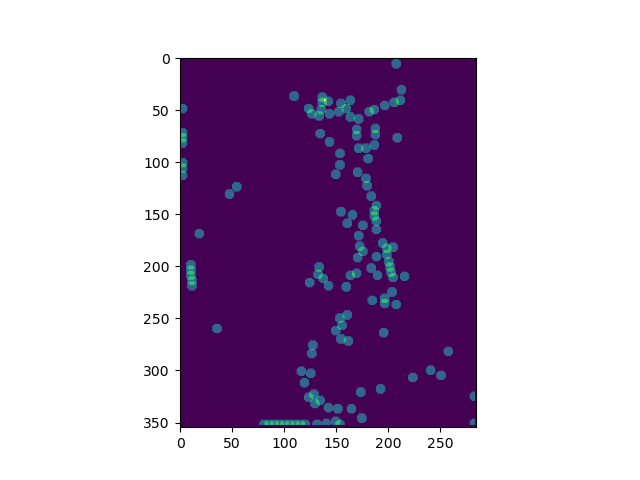


#What do you see here: 

The mask indicates that from a circle you see there was taken a feature which satisffies MCD, and the circle itself indicates that no other features were taken from the area during the run of find_features_satisfy_min_distance, because we marked that region by adding ones to the mask everywhere where circle of radius < min_distance. 

Why do you see more empahsized (colored)  intersected regions ?
Because those are intersections of circles. That means that two close points which do sattisfy MCD were taken, their distance is at least min_distance, but ones were added more then one to the locations in the intersections, so that area is restricted few times, but we don't care, because only zeros are the areas from which is possible to take features.

In [297]:
#first approach implementation
def filter_features_by_dist(features, min_distance):
    new_features = list([features[0]])
    del features[0]
    for i in range(len(features)):
        count=0
        for j in range(len(new_features)):
            if calc_pixel_dist(features[i], new_features[j]) < min_distance:
                break
            count+=1
        if count == len(new_features):
            new_features.append(features[i])
    return new_features

In [298]:
#second approach implementation
import cv2
import numpy as np

def compute_mask_for_circle_radius(circle_radius):
    circle_range = list(range(- circle_radius, circle_radius + 1))
    kernel_size = circle_radius * 2 + 1
    neighbors_indices_y = np.asarray(circle_range).reshape(-1, kernel_size).repeat(kernel_size, axis=0)
    neighbors_indices_x = np.asarray(circle_range).reshape(kernel_size, -1).repeat(kernel_size, axis=-1)

    neighbors_indices = np.stack((neighbors_indices_y, neighbors_indices_x), axis=-1)
    spatial_distance = np.sqrt(np.sum((neighbors_indices ** 2), axis=-1))
    circle_mask = (spatial_distance < circle_radius).astype("int")

    return circle_mask



def find_features_satisfy_min_distance(image, th, neighbor_radius, min_distance):
    assert th > 0
    pad = neighbor_radius
    padded_img = cv2.copyMakeBorder(image, pad, pad, pad, pad,
                                    cv2.BORDER_CONSTANT,
                                    value=(0, 0, 0))
    height, width, _ = padded_img.shape
    kernel_size = neighbor_radius * 2 + 1
    features = list()

    circle_kernel = compute_mask_for_circle_radius(min_distance)
    img_mask = np.zeros((padded_img.shape[0], padded_img.shape[1]), dtype="int")

    for y in range(pad, height - pad):
        for x in range(pad, width - pad):
            # the second check shoudl work because we filter the image
            if len(features) == 0 or img_mask[y, x] == 0:
                pixel_rgb = padded_img[y, x]
                pixel_rgb_kernel = np.zeros((kernel_size, kernel_size, 3)) + pixel_rgb
                cur_image_region = padded_img[y - neighbor_radius: y + neighbor_radius + 1,
                                   x - neighbor_radius: x + neighbor_radius + 1]
                num_of_neighbors = kernel_size ** 2 - 1
                score = np.sum(np.sqrt(np.sum((pixel_rgb_kernel - cur_image_region) ** 2, axis=2))) / num_of_neighbors
                if score > th:
                    features.append([y, x])
                    y_start = max(y - min_distance, 0)
                    x_start = max(x - min_distance, 0)
                    y_end = min(y + min_distance + 1, height - pad)
                    x_end = min(x + min_distance + 1, width - pad)
                    truncated_y_start = y - min_distance
                    truncated_x_start = x - min_distance
                    truncated_y_end = (height - pad) - (y + min_distance + 1)
                    truncated_x_end = (width - pad) - (x + min_distance + 1)

                    img_mask[y_start: y_end, x_start: x_end] += \
                        circle_kernel[
                            (truncated_y_start < 0) * (-truncated_y_start) :
                            min_distance * 2 + 1 + (truncated_y_end < 0) * (truncated_y_end),
                            (truncated_x_start < 0) * (-truncated_x_start):
                            min_distance * 2 + 1 + (truncated_x_end < 0) * (truncated_x_end)
                            ]

    return features

In [299]:
th = 120
neighbor_radius = 2
features = find_features(img, th, neighbor_radius)
min_distance = 5
filtered_features = filter_features_by_dist(features, min_distance)

print(len(filtered_features))

167


The second implementation doesnt give yet the same number, but it is close.

In [300]:
th = 120
neighbor_radius = 2
min_distance = 5
features = find_features_satisfy_min_distance(img, th, neighbor_radius, min_distance)
print(len(features))


167


In [301]:
check_filtered_in_features =  all(item in features for item in filtered_features)
print(check_filtered_in_features)
check_features_in_filtered =  all(item in filtered_features for item in features)
print(check_features_in_filtered)

print("Equal result in two different approaches")

True
True
Equal result in two different approaches


#Q3.2 code

#Notice the difference in run time for a big number of features due to low threshold (th = 50 in tested case):

First approach:



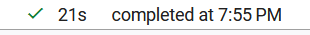

Second approach:



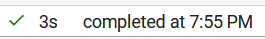

for th = 120 for example the run time of first approach is 4 seconds and for the second approach is 2 seconds.

First we will add score along the indices of the feature.

In [302]:
def find_features_scores(image, th, neighbor_radius):
    assert th > 0
    pad = effective_radius = neighbor_radius
    padded_img = cv2.copyMakeBorder(image, pad, pad, pad, pad,
                                    cv2.BORDER_CONSTANT,
                                    value=(0,0,0))
    height, width, _ = padded_img.shape
    kernel_size = effective_radius * 2 + 1
    features = list()
    for y in range(pad, height - pad):
        for x in range(pad, width - pad):
            pixel_rgb = padded_img[y, x]
            prgb_kernel = np.zeros((kernel_size, kernel_size, 3)) + pixel_rgb
            cur_image_region = padded_img[y - effective_radius : y + effective_radius + 1,
                                     x - effective_radius : x + effective_radius + 1]
            score = np.mean(np.sqrt(np.sum((prgb_kernel - cur_image_region) ** 2, axis=2)))
            if score > th :
                features.append([y, x, score])
    return features

In [303]:
max_features = 20
th = 120
neighbor_radius = 2
features = find_features_scores(img, th, neighbor_radius)

def take_score(feature):
 return feature[2]

sorted_features = sorted(features, key=take_score, reverse=True)

top_max_features = sorted_features[:max_features]
print(len(top_max_features))

"And the top features with the highest score are"
top_max_features

20


[[232, 196, 234.6582434094315],
 [233, 196, 214.22004388011877],
 [234, 196, 191.63410134942058],
 [352, 140, 191.07984509099856],
 [87, 172, 185.26015437756712],
 [212, 205, 184.0823598284203],
 [231, 196, 182.0038988593376],
 [235, 196, 179.3711816318329],
 [352, 139, 176.46133627511722],
 [208, 169, 173.41292685379597],
 [87, 173, 173.2743627891905],
 [55, 143, 167.66251817266732],
 [50, 135, 166.83113378503424],
 [285, 126, 162.81277591147446],
 [210, 162, 162.53564778226342],
 [352, 141, 162.18923762074965],
 [44, 154, 161.77354542693314],
 [219, 11, 161.70426339463037],
 [209, 169, 161.56569933002487],
 [211, 205, 160.66503291008905]]

#Well, finally it is correct to say that the number of features in the real application won't be that large, so the optimization in this case maybe won't be as big as in this case, where the number of features was around thousands.